<a href="https://colab.research.google.com/github/alimoorreza/CS195-Fall24-Notebook-3/blob/main/cs195_notebook3_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__Notebook \# 3__
Name: Alimoor Reza

Date: 10/02/2024


####**Hints/Tips Tricks**
If you want to accelerate the training process using graphical processing unit (GPU), do so from Colab's 'Notebook Settings' by enabling GPU:
> Runtime-->Change runtime type-->GPU or TPU


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#__Fine-tuning a Pretrained Convolutional Neural Network (CNN) for image classification__


* AlexNet was the winner of ImageNet challenge in 2012 @ University of Toronto.
> [A. Krizhevsky, I. Sutskever, and G. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, NIPS 2012](www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

* VGG was the winner of ImageNet (1000-class image classification) challenge in 2014. @ Oxford University.
> [Very Deep Convolutional Networks for Large-Scale Image Recognition - Karen Simonyan and Andrew Zisserman](https://arxiv.org/abs/1409.1556)


* ResNet was the winner of ImageNet challenge in 2015. @ Microsoft Research.
> [Deep Residual Learning for Image Recognition - Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1409.1556)





#__Dataset visualization__
Download the dataset from the following link:

- [Underwater Animal Dataset (full)](https://analytics.drake.edu/~reza/teaching/cs195_fall24/datasets/uws_v1_full.zip)
  - Each image size: __HxWx3__
    - Note that these are color images
  - Each image is associated with a label from __C classes__
  - Training set of __N__ examples and test set of __M__ examples



  
<!--div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/cifar-10-sprite.png" width=500/>
</div-->


In [6]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pdb
root_dir                    = "/content/drive/MyDrive/cs195_fall24/classification/datasets/uws_v1_full/train/"
name_of_the_water_animals    = os.listdir(root_dir)
if '.DS_Store' in name_of_the_water_animals:
  name_of_the_water_animals.remove('.DS_Store')

name_of_the_water_animals.sort()
sample_images = {}

print("Selected underwater animals for classification task: ")
print("-------------------------------------------------------------------------")
for i in range(len(name_of_the_water_animals)):
  # select a random training image
  all_image_names_cur_species = os.listdir(root_dir + "/" + name_of_the_water_animals[i])
  random_index  = torch.randint(len(all_image_names_cur_species), size=(1,)).item()
  img           = cv2.imread(root_dir + "/" + name_of_the_water_animals[i] + "/" + all_image_names_cur_species[random_index])
  resized_img   = cv2.resize(img, (100, 100))
  sample_images[name_of_the_water_animals[i]] = {'img':resized_img, 'train_size':len(all_image_names_cur_species)}

  # display the name of the species
  print(f"{i+1:2}. {name_of_the_water_animals[i]:>25}: {len(all_image_names_cur_species):>20} training samples")

print("-------------------------------------------------------------------------")

Selected underwater animals for classification task: 
-------------------------------------------------------------------------
 1.                      Crab:                   24 training samples
 2.                 Crocodile:                   24 training samples
 3.                   Dolphin:                   24 training samples
 4.                      Frog:                   12 training samples
 5.                   Nettles:                   25 training samples
 6.                Nudibranch:                   24 training samples
 7.                   Octopus:                   25 training samples
 8.                     Otter:                   24 training samples
 9.                   Penguin:                   24 training samples
10.                Polar_bear:                   24 training samples
11.               Sea_anemone:                   13 training samples
12.                Sea_urchin:                   13 training samples
13.                  Seahorse:              

In [4]:
print(root_dir + "/" + name_of_the_water_animals[i] + "/" + all_image_names_cur_species[random_index])

/content/drive/MyDrive/cs195_fall24/classification/datasets/uws_v1_full/train//Stingray/.DS_Store


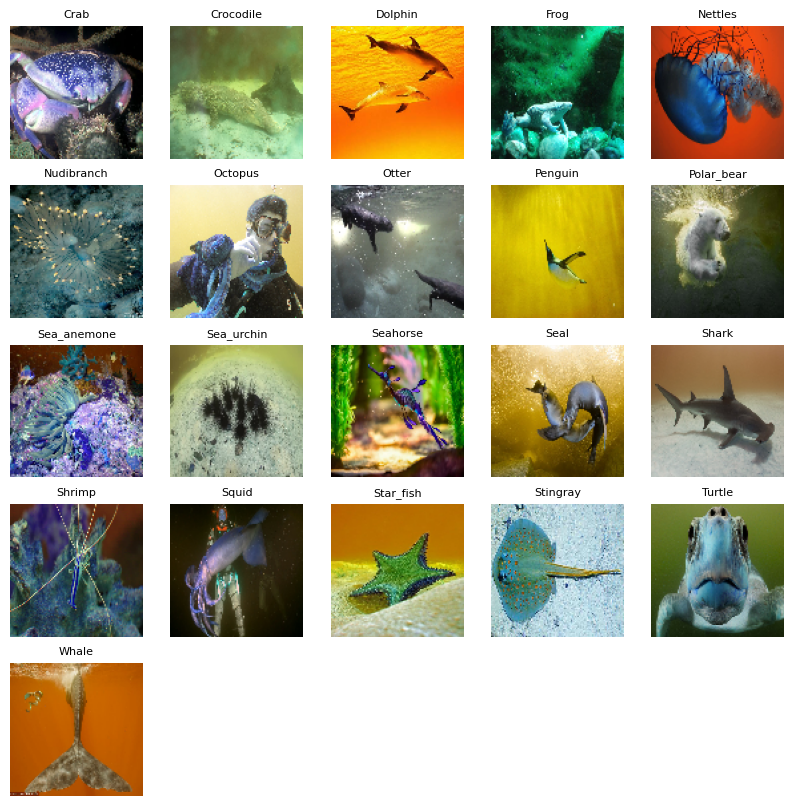

In [8]:
# showing some sample training images
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows - 3):
  cur_sample = sample_images[name_of_the_water_animals[i-1]]
  img   = cur_sample['img']
  label = name_of_the_water_animals[i-1]
  figure.add_subplot(rows, cols, i)
  plt.title(label, fontsize=8)
  plt.axis("off")
  plt.imshow(img)
plt.show()


#__Network Codes for AlexNet, VGGNet, and ResNet__
You can use the following network classes when you fine-tune your models.

In [ ]:
# CNN networks preparation for fine-tuning:
#     1) AlexNet
#     2) VGGNet
#     3) Res18Net
#     4) Res50Net
#     5) Res152Net
#-----------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
import os
import pdb


# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained VGG model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'

# ---------------
# 1. AlexNet
# ---------------
class AlexNet(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(AlexNet, self).__init__()

        # download PyTorch's own implementation of AlexNet model trained on ImageNet dataset
        net             = models.alexnet(pretrained=True)


        # retained weightes for convolutional, pooling, linear layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool
        self.classifier = net.classifier

        # IMPORTANT: "If you need to fine-tune this network for your own dataset,
        # the simplest modification is to replace the last layer in self.classifier with
        # the updated AlexNet has the desired number of output classes: 'num_classes'
        self.classifier[-1] = nn.Linear(4096, num_classes) # only this last layer's weights will be trained from scratch


    def forward(self, x):


        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



# ---------------
# 2. VGGNet
# ---------------

class VGGNet(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(VGGNet, self).__init__()

        # download PyTorch's own implementation of VGG model trained on ImageNet dataset
        net = models.vgg16(pretrained=True)

        # retained weightes for convolutional, pooling, linear layers from VGG-16
        self.features   = net.features
        self.avgpool    = net.avgpool
        self.classifier = net.classifier

        # IMPORTANT: "If you need to fine-tune this network for your own dataset,
        # the simplest modification is to replace the last layer in self.classifier with
        # the updated VGGNet has the desired number of output classes: 'num_classes'
        self.classifier[-1] = nn.Linear(4096, num_classes) # only this last layer's weights will be trained from scratch


    def forward(self, x):

        print("shape of input: ", x.shape)
        x = self.features(x)
        print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        print("output shape (self.classifier): ", x.shape)
        return x



# ---------------
# 3. Res18Net
# ---------------
class Res18Net(nn.Module):

    def __init__(self, num_classes, pretrained=True):

        super(Res18Net, self).__init__()

        # download PyTorch's own implementation of VGG model trained on ImageNet dataset
        net = models.resnet18(pretrained=True)

        # retained weightes for convolutional, maxpooling, and linear layers from ResNet
        self.conv1    = net.conv1
        self.bn1      = net.bn1
        self.relu     = net.relu
        self.maxpool  = net.maxpool

        self.layer1   = net.layer1
        self.layer2   = net.layer2
        self.layer3   = net.layer3
        self.layer4   = net.layer4

        self.avgpool  = net.avgpool
        self.fc       = net.fc

        # IMPORTANT: "If you need to fine-tune this network for your own dataset,
        # the simplest modification is to replace the last layer in self.classifier with
        # the updated ResNet has the desired number of output classes: 'num_classes'
        self.classifier[-1] = nn.Linear(4096, num_classes) # only this last layer's weights will be trained from scratch


    def forward(self, x):

        print("shape of input: ", x.shape)
        x = self.features(x)
        print("output shape (self.features): ", x.shape)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        print("output shape (self.fc): ", x.shape)

        return x


# ---------------
# 4. Res50Net
# ---------------
# finish the structure of Res50Net
# ...
# ...
# ...
# ...
# ...




# ---------------
# 5. Res152Net
# ---------------
# finish the structure of Res50Net
# ...
# ...
# ...
# ...
# ...




#__Model 1: AlexNet for fine-tuning and evaluating__

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# finish remaining part
# ...
# ...
# ...
# ...
# ...

In [ ]:
# visualize the accuracy curves for AlexNet


In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['Crocodile',  'Dolphin', 'Octopus',   'Otter',  'Penguin', \
                  'Polar_bear', 'Squid',   'Star_fish', 'Turtle', 'Whale'] # datasets.ImageFolder(): assigns labels according to the sorted order of the folder names


# your code goes here for building the confusion matrix

#__Model 2: VGGNet for fine-tuning and evaluating__

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# finish remaining part
# ...
# ...
# ...
# ...
# ...

#__Model 3: Res18Net for fine-tuning and evaluating__:

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# finish remaining part
# ...
# ...
# ...
# ...
# ...

#__Model 4: Res50Net for fine-tuning and evaluating__:

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# finish remaining part
# ...
# ...
# ...
# ...
# ...

#__Model 5: Res152Net for fine-tuning and evaluating__:

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# util function:
def get_imagenet_mean_std_normalized():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return mean, std

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# finish remaining part
# ...
# ...
# ...
# ...
# ...